# **1. VERİ İŞLEME** #

# - Kütüphaneler #

Projede kullanılacak kütüphanelerin dahil edilmesi.

In [36]:
# Gerekli kütüphaneleri yüklüyoruz
import numpy as np  # Sayısal hesaplamalar için NumPy kütüphanesini içe aktarıyoruz
import pandas as pd  # Veri analizi ve manipülasyonu için Pandas kütüphanesini içe aktarıyoruz
import matplotlib.pyplot as plt  # Görselleştirme için Matplotlib kütüphanesini içe aktarıyoruz
from sklearn.model_selection import train_test_split  # Veri setini eğitim ve test olarak ayırmak için fonksiyonu içe aktarıyoruz
from keras.preprocessing.image import load_img, img_to_array  # Görüntü işleme için gerekli fonksiyonları içe aktarıyoruz
from tqdm import tqdm  # İlerleme çubuğu oluşturmak için kütüphaneyi içe aktarıyoruz
import seaborn as sns  # Gelişmiş veri görselleştirme için Seaborn kütüphanesini yüklüyoruz
from sklearn.metrics import classification_report, confusion_matrix  # Model performansını değerlendirmek için metrikleri içe aktarıyoruz
import tensorflow as tf  # TensorFlow kütüphanesini içe aktarıyoruz
import os  # İşletim sistemi ile etkileşim için os kütüphanesini içe aktarıyoruz
from tensorflow.keras.models import Sequential  # Model oluşturmak için Sequential sınıfını içe aktarıyoruz
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout  # CNN katmanlarını içe aktarıyoruz
from tensorflow.keras.optimizers import Adam  # Adam optimizasyon algoritmasını içe aktarıyoruz
import warnings  # Uyarı yönetimi için warnings kütüphanesini içe aktarıyoruz

warnings.filterwarnings("ignore")  # Uyarıları gizlemek için kullanıyoruz

# - Veri setini Tanımlama #

Verilerin okunması ve data_directory'e aktarılması.

In [37]:
# Resim dosyalarının bulunduğu ana dizin
data_directory = '//kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'

# Bu dizindeki alt klasörler (balık sınıfları) alınıyor. '.' içermeyen klasörler sınıf isimleridir.
fish_classes = [folder for folder in os.listdir(data_directory) if '.' not in folder]
fish_classes  # Bulunan balık türlerini listele

['Hourse Mackerel',
 'Black Sea Sprat',
 'Sea Bass',
 'Red Mullet',
 'Trout',
 'Striped Red Mullet',
 'Shrimp',
 'Gilt-Head Bream',
 'Red Sea Bream']

In [38]:
# Resim dosyalarının yolları ve etiketleri için başlangıçta boş listeler oluşturuluyor
image_labels = []  # Resim etiketleri için liste
file_paths = []  # Resim dosya yolları için liste

# Belirtilen dizindeki dosya yapısını gezerek işlemler yapıyoruz
for directory, _, files in os.walk(data_directory):
    for file in files:
        # Sadece '.png' uzantılı dosyaları işleme alıyoruz
        if file.endswith('.png'):
            # Eğer 'GT' (ground truth) klasöründe değilse etiketi al
            if 'GT' not in os.path.basename(directory):            
                image_labels.append(os.path.basename(directory))  # Klasör ismini etiketi olarak ekle
                file_paths.append(os.path.join(directory, file))  # Dosya yolunu listeye ekle

# Elde edilen resim yolları ve etiketler ile bir DataFrame oluşturuyoruz
dataset = pd.DataFrame(columns=['path', 'label'])  # Boş bir DataFrame oluştur
dataset['path'] = file_paths  # Resim yollarını ekliyoruz
dataset['label'] = image_labels  # Etiketleri ekliyoruz

In [39]:
dataset

path            label
0     //kaggle/input/a-large-scale-fish-dataset/Fish...  Hourse Mackerel
1     //kaggle/input/a-large-scale-fish-dataset/Fish...  Hourse Mackerel
2     //kaggle/input/a-large-scale-fish-dataset/Fish...  Hourse Mackerel
3     //kaggle/input/a-large-scale-fish-dataset/Fish...  Hourse Mackerel
4     //kaggle/input/a-large-scale-fish-dataset/Fish...  Hourse Mackerel
...                                                 ...              ...
8995  //kaggle/input/a-large-scale-fish-dataset/Fish...    Red Sea Bream
8996  //kaggle/input/a-large-scale-fish-dataset/Fish...    Red Sea Bream
8997  //kaggle/input/a-large-scale-fish-dataset/Fish...    Red Sea Bream
8998  //kaggle/input/a-large-scale-fish-dataset/Fish...    Red Sea Bream
8999  //kaggle/input/a-large-scale-fish-dataset/Fish...    Red Sea Bream

[9000 rows x 2 columns]

# - Birkaç Satır ve Temel Bilgileri Gösterme #

In [40]:
# İlk resim yolunu görüntülüyoruz (index 0'daki)
first_image_path = dataset.path.iloc[0]  # .iloc kullanarak ilk resim yolunu alıyoruz
first_image_path

'//kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00929.png'

In [41]:
# Veri setinin yapısına göz atalım
print(dataset.info())

# Veri setinden örnek satırlar görüntüleyerek genel yapısına dair bir fikir edinelim
sample_data = dataset.head()  # İlk 5 satırı seçiyoruz
print(sample_data)

# Her balık sınıfının veri setindeki sayısını belirleyelim
# Bu, her etiketin ne kadar temsil edildiğini anlamamıza yardımcı olur
fish_class_distribution = dataset['label'].value_counts()
print("Numbers of fish classes:\n", fish_class_distribution)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB
None
                                                path            label
0  //kaggle/input/a-large-scale-fish-dataset/Fish...  Hourse Mackerel
1  //kaggle/input/a-large-scale-fish-dataset/Fish...  Hourse Mackerel
2  //kaggle/input/a-large-scale-fish-dataset/Fish...  Hourse Mackerel
3  //kaggle/input/a-large-scale-fish-dataset/Fish...  Hourse Mackerel
4  //kaggle/input/a-large-scale-fish-dataset/Fish...  Hourse Mackerel
Numbers of fish classes:
 label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: co

# - Veri Görselleştirme #

Veri setindeki türlerin dağılımı görsel olarak sınıflandırılmıştır.

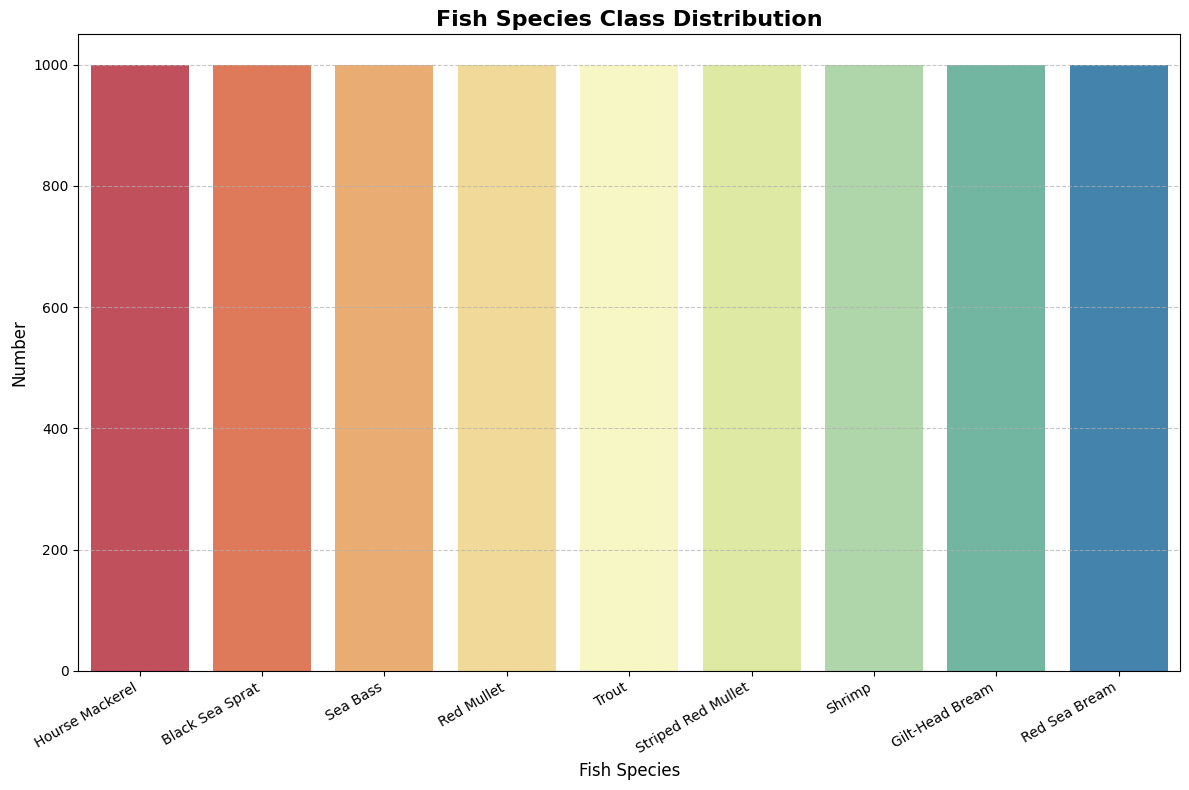

In [42]:
# Balık türlerinin dağılımını görsel olarak inceleyelim
plt.figure(figsize=(12, 8))  # Görüntü boyutunu ayarlıyoruz
sns.countplot(data=dataset, x='label', palette='Spectral')  # Çubuk grafikle sınıf sayılarını gösteriyoruz
plt.title('Fish Species Class Distribution', fontsize=16, fontweight='bold')  # Grafik başlığını kalın yapıyoruz
plt.xlabel('Fish Species', fontsize=12)  # X eksenine etiket ekliyoruz
plt.ylabel('Number', fontsize=12)  # Y eksenine etiket ekliyoruz
plt.xticks(rotation=30, ha='right', fontsize=10)  # X eksenindeki etiketleri döndürerek hizalıyoruz
plt.yticks(fontsize=10)  # Y ekseni etiket boyutunu ayarlıyoruz
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Y eksenine kılavuz çizgileri ekliyoruz
plt.tight_layout()  # Grafik düzenini iyileştiriyoruz
plt.show()  # Grafiği ekranda gösteriyoruz

Her sınıftan birkaç örnek gösterme.

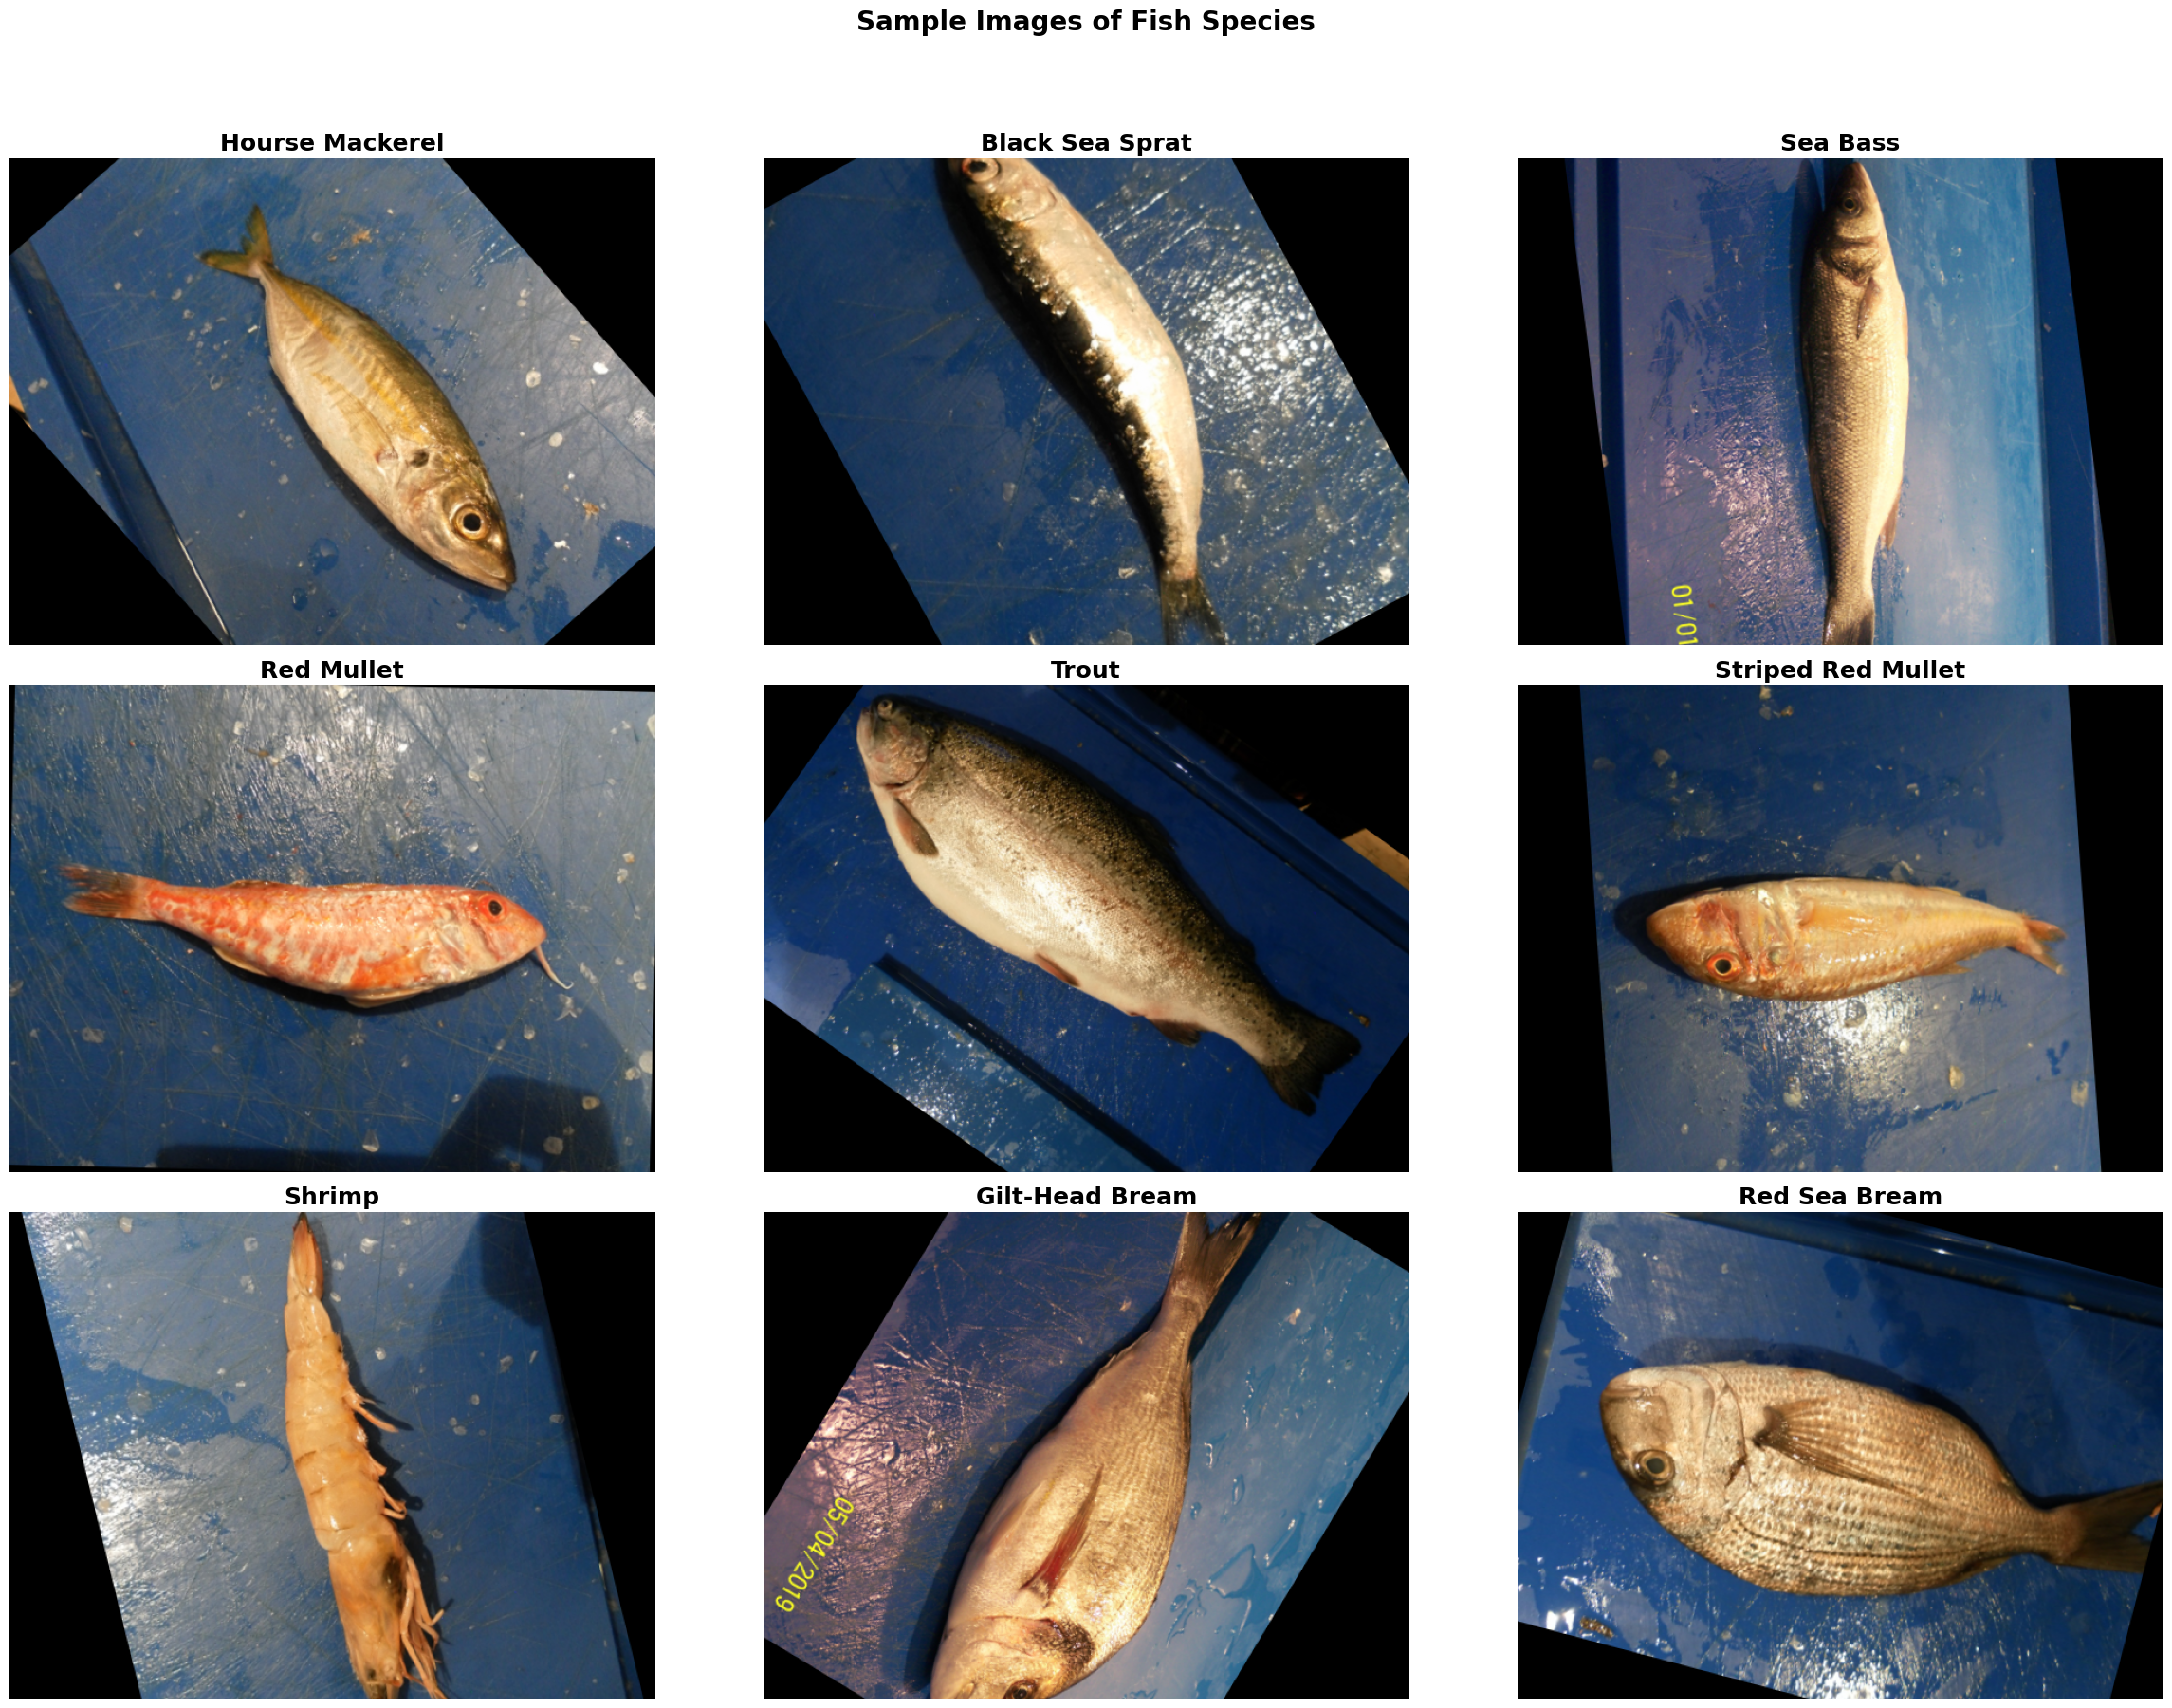

In [43]:
# Her sınıftan birkaç örnek görüntüyü görselleştirelim
plt.figure(figsize=(24, 24))  # Grafik boyutunu ayarlıyoruz
# İlk 9 balık sınıfını gösterecek şekilde döngü oluşturuyoruz
for i, label in enumerate(dataset['label'].unique()[:9]):  
    plt.subplot(4, 3, i + 1)  # 4x3'lük alt grafik oluşturuyoruz
    # İlgili sınıfa ait ilk görüntüyü yüklüyoruz
    image_path = dataset[dataset['label'] == label].iloc[0, 0]  
    img = plt.imread(image_path)
    plt.imshow(img)  # Resmi yüklüyoruz
    plt.title(label, fontsize=18, fontweight='bold')  # Sınıf adını başlık olarak ekliyoruz
    plt.axis('off')  # Eksenleri kapatıyoruz

plt.suptitle('Sample Images of Fish Species', fontsize=20, fontweight='bold')  # Üst başlık ekliyoruz
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Alt grafiklerin düzenini iyileştiriyoruz
plt.show()  # Grafiği gösteriyoruz

# **2. Model** #

In [44]:
# Veri setini eğitim ve test olarak ayırıyoruz.
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42, stratify=dataset['label'])

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    try:
        img = load_img(image_path, target_size=target_size)  # Görüntüyü belirtilen boyutta yüklüyoruz
        img_array = img_to_array(img)  # Görüntüyü dizi formatına çeviriyoruz
        return img_array / 255.0  # Piksel değerlerini normalize ediyoruz
    except Exception as e:
        print(f"Error: {e}. {image_path} could not be loaded.")
        return None #Hata durumunda mesaj göster

# Eğitim verileri için X_train ve y_train hazırlıyoruz
X_train = np.array([img for img in (load_and_preprocess_image(path) for path in tqdm(train_set['path'], desc="Loading Training Images")) if img is not None])
y_train = pd.get_dummies(train_set['label']).values  # Etiketleri one-hot encoding ile dönüştürüyoruz

# Test verileri için X_test ve y_test hazırlıyoruz
X_test = np.array([img for img in (load_and_preprocess_image(path) for path in tqdm(test_set['path'], desc="Loading Test Images")) if img is not None])
y_test = pd.get_dummies(test_set['label']).values  # Test etiketlerini one-hot encoding ile dönüştürüyoruz

# Eğitim ve test setlerinin boyutlarını yazdırıyoruz
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Loading Test Images: 100%|██████████| 1800/1800 [00:16<00:00, 106.21it/s]


Training set size: (7200, 224, 224, 3)
Test set size: (1800, 224, 224, 3)


# **3. Modelin Tanımlanması** #

In [45]:
# Model oluşturma
model = Sequential()

# İlk Convolutional Katman
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(2, 2))

# İkinci Convolutional Katman
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# Üçüncü Convolutional Katman
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

# Flatten Katmanı
model.add(Flatten())

# Tam Bağlantılı Katmanlar
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Çıkış Katmanı (Sınıf sayısına göre)
model.add(Dense(9, activation='softmax'))  # Sınıf sayısı dataset'e göre ayarlanmış

# Modeli derlemek
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model özeti
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,278,729 (84.99 MB)

 Trainable params: 22,278,729 (84.99 MB)

 Non-trainable params: 0 (0.00 B)

# **4. Modelin Eğitilmesi ve Geliştirilmesi**  #

In [46]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model eğitimi
history = model.fit(
    X_train,                # Eğitim verileri
    y_train,                # Eğitim etiketleri
    epochs=20,              # Eğitim döngü sayısı (20 epoch ile başlatılıyor)
    batch_size=32,          # Her iterasyonda işlenecek görüntü sayısı
    validation_split=0.2,   # Eğitim verilerinin %20'si doğrulama için ayrılacak
    callbacks=[early_stopping]  # Erken durdurma ile aşırı öğrenmeyi engelleme
)

Epoch 1/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.2231 - loss: 2.1528 - val_accuracy: 0.7278 - val_loss: 0.9721
Epoch 2/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.6610 - loss: 0.9795 - val_accuracy: 0.8868 - val_loss: 0.3857
Epoch 3/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.8391 - loss: 0.4830 - val_accuracy: 0.9299 - val_loss: 0.2470
Epoch 4/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.9149 - loss: 0.2721 - val_accuracy: 0.9674 - val_loss: 0.1263
Epoch 5/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.9465 - loss: 0.1766 - val_accuracy: 0.9701 - val_loss: 0.0944
Epoch 6/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9523 - loss: 0.1447 - val_accuracy: 0.9778 - val_loss: 0.0659
Epoch 7/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9577 - loss: 0.1371 - val_accuracy: 0.9556 - val_loss: 0.1592
Epoch 8/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.9682 - loss: 0.1021 - val_acc

# - Accuracy ve Loss Grafiği #

Eğitim kayıplarını ve doğruluğu görselleştirelim 

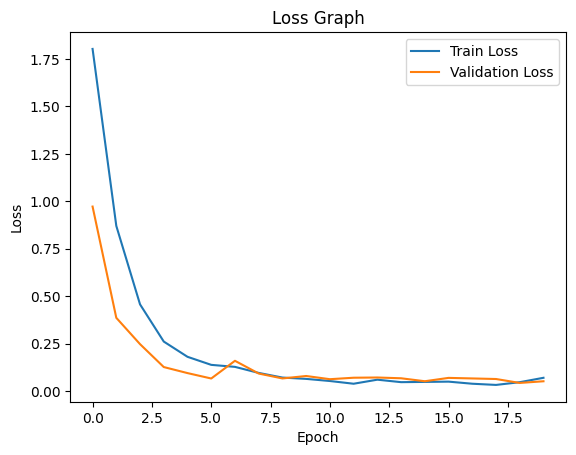

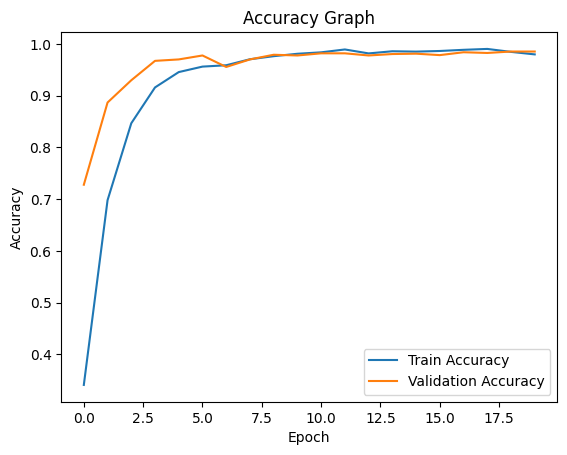

In [47]:
# Kayıp (Loss) grafiği
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Doğruluk (Accuracy) grafiği
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# - Modelin Değerlendirilmesi #

In [48]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9782 - loss: 0.0733
Test Loss: 0.0836
Test Accuracy: 0.9783


In [49]:
# Modelin test verileri üzerindeki tahminleri
y_pred_probs = model.predict(X_test)  # Tahmin edilen olasılıklar
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # En yüksek olasılığa sahip sınıfı seçiyoruz

# Gerçek sınıfları elde ediyoruz
y_true_classes = np.argmax(y_test, axis=1)  # One-hot encoding'den orijinal sınıf etiketlerine dönüştürüyoruz

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [50]:
from sklearn.metrics import classification_report

# Sınıflandırma raporu
print(classification_report(y_true_classes, y_pred_classes, target_names=dataset['label'].unique()))

                    precision    recall  f1-score   support

   Hourse Mackerel       0.98      0.99      0.99       200
   Black Sea Sprat       0.99      0.96      0.98       200
          Sea Bass       0.99      0.99      0.99       200
        Red Mullet       0.99      0.99      0.99       200
             Trout       0.99      0.98      0.98       200
Striped Red Mullet       0.99      0.93      0.96       200
            Shrimp       0.99      0.96      0.98       200
   Gilt-Head Bream       0.95      0.99      0.97       200
     Red Sea Bream       0.95      1.00      0.97       200

          accuracy                           0.98      1800
         macro avg       0.98      0.98      0.98      1800
      weighted avg       0.98      0.98      0.98      1800



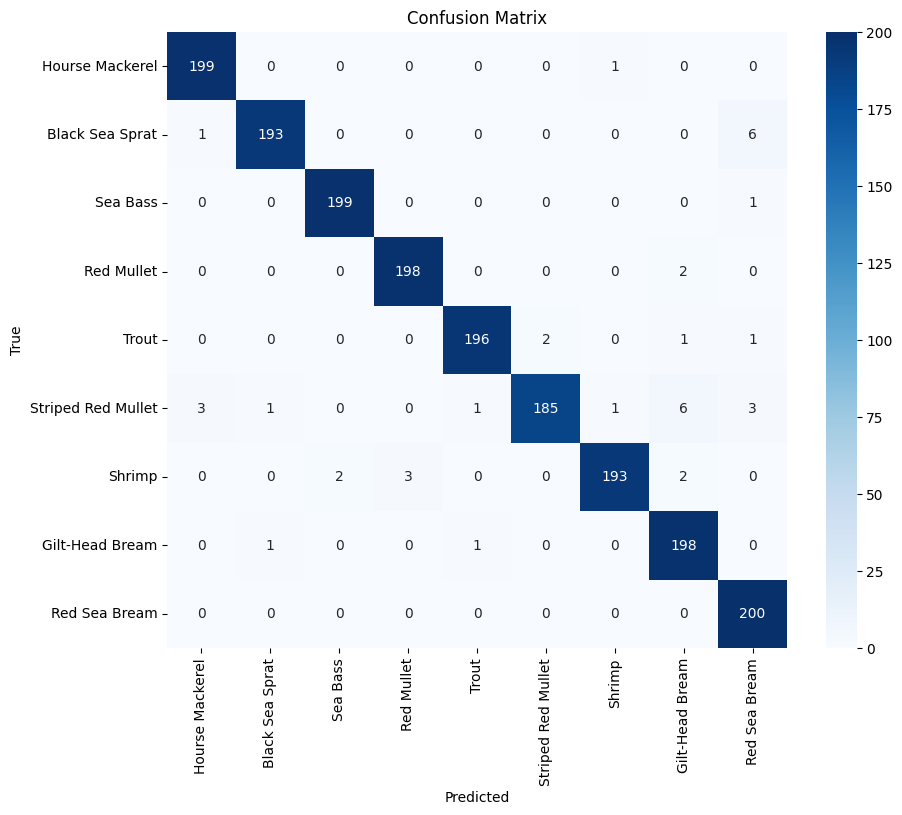

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Karışıklık matrisi
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Karışıklık matrisini görselleştirme
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset['label'].unique(), yticklabels=dataset['label'].unique())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# **5. Veri Setindeki Görüntüyü Sınıflandırma ve Tahmin İşlemi** #

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


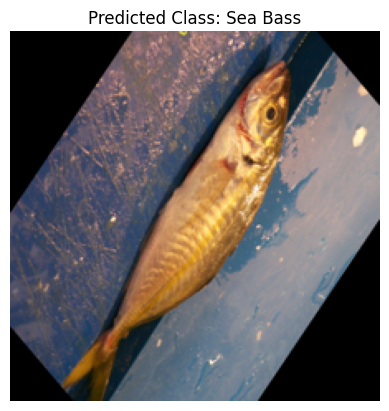

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Örnek bir resim yükleme (Pillow ile)
image_path = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00030.png'

# Görüntüyü Pillow ile aç, boyutlandır ve normalize et
test_img = Image.open(image_path)  # Görüntüyü aç
test_img = test_img.resize((224, 224))  # Modelin beklediği boyut (224x224) olacak şekilde yeniden boyutlandır
test_img_array = np.array(test_img).astype('float32') / 255  # NumPy dizisine dönüştür ve normalize et

# Modelin beklediği formatta giriş oluşturmak için boyutları genişlet
test_img_array = np.expand_dims(test_img_array, axis=0)  # (1, 224, 224, 3) boyutuna genişlet

# Modelden tahmin yapma
predictions = model.predict(test_img_array)

# Tahmin edilen sınıf indeksini bulma
predicted_class_index = np.argmax(predictions)

# Dataset içindeki etiket isimlerini alıyoruz
class_names = dataset['label'].unique()  # Sınıf isimlerini elde ediyoruz

# Tahmin edilen sınıf ismi
predicted_class = class_names[predicted_class_index]

# Tahmin sonucunu görselleştirme (Pillow ile)
plt.imshow(test_img)  # test_img PIL imaj nesnesidir, NumPy dizisi değil
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')  # Eksenleri gizle
plt.show()